# Multi-Factor Prediction of Mental Illness Incidence Rates
**Quinn Bischoff, Eric Matteucci, Rajat Singh, Daniel Velasco**

# Phase II

## Introduction

Behavioural and emotional well-being is integral to the development of societies around the world. However, the rates of incidence of mental health disorders are on the rise in some places around the globe, while others are declining. Our goal is to predict these incidence rates using linear regression and deep learning methods on a rich data set.

Using a combination of data sets that include news headlines, financial indicators, and population distributions and indices, to generate a prediction of incidence of disorders such as depression or anxiety, and deaths by mental health. To this end, news headlines that originate from a given country will be preprocessed using natural language processing (NLP)—specifically, sentiment analysis. The score, in conjunction with the aforementioned datasets, will be used to generate a linear regression model and a neural network. The ultimate goal of this project is to determine whether news headline sentiments from a country are accurate at predicting the mental health disorder rate of the country.

## Phase II Goal
The aim of this phase is to ...

[X] methods will be employed:
1. First
2. ...
X. Last


#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore')

from functools import reduce

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from textblob import TextBlob


#### Constants

In [2]:
# column names
COL_COUNTRY = 'country'
COL_GDP = 'GDP'
COL_HDI = 'HDI'
COL_POLARITY = 'polarity'
COL_POPULATION_DENSITY = 'population density'
COL_SUBJECTIVITY = 'subjectivity'
COL_UNEMPLOYMENT = 'unemployment rate'
COL_URBAN_DENSITY = 'urban density (%)'
COL_YEAR = 'year'
COL_NEWS_TEMPLATE = 'news{}'

TARGETS = [
    'Bipolar disorder (%)',
    'Eating disorders (%)',
    'Anxiety disorders (%)',
    'Drug use disorders (%)',
    'Depression (%)',
    'Alcohol use disorders (%)',
]

FEATURES = [
    COL_GDP,
    COL_HDI,
    COL_POLARITY,
    COL_POPULATION_DENSITY,
    COL_SUBJECTIVITY,
    COL_UNEMPLOYMENT,
    COL_URBAN_DENSITY,
]

SENTIMENT_FEATURES = [
    COL_POLARITY,
    COL_SUBJECTIVITY
]

# directories and filenames
DIR_DATA = 'data'
DIR_FINANCIAL = os.path.join(DIR_DATA, 'financial')
DIR_HDI = os.path.join(DIR_DATA, 'human_development_index')
DIR_MENTAL_HEALTH = os.path.join(DIR_DATA, 'mental_health')
DIR_NEWS = os.path.join(DIR_DATA, 'news')
DIR_POPULATION = os.path.join(DIR_DATA, 'population')

FILENAME_DISORDERS = 'prevalence-by-mental-and-substance-use-disorder.csv'
FILENAME_GDP = 'wrldbnk_gdp.csv'
FILENAME_HDI = 'hdi.csv'
FILENAME_NEWS_HEADLINES = 'news_headlines.csv'
FILENAME_POPULATION_DENSITY = 'wrldbnk_pop_dnst.csv'
FILENAME_UNEMPLOYMENT = 'wrldbnk_unemployment.csv'
FILENAME_URBAN_DENSITY = 'wrldbnk_urban_pop.csv'

# Years
DATE_START = '2005'
DATE_END = '2018'

DATE_RANGE = [str(i) for i in range(2005, 2018)]
DATE_NEWS_FROM = ['{}-02-02', '{}-05-05', '{}-07-07', '{}-11-11']
DATE_NEWS_TO = ['{}-03-03', '{}-06-06','{}-08-08', '{}-12-12']


# country values
SELECTED_COUNTRIES = [
    'south africa',
    'kenya',
    'china',
    'taiwan',
    'japan',
    'south korea',
    'india',
    'pakistan',
    'indonesia',
    'philippines',
    'singapore',
    'thailand',
    'canada',
    'united kingdom',
    'ireland',
    'scotland',
    'australia',
    'new zealand',
    'united states',
]


COUNTRIES_DICT = {
    'australia' : 'australia',
    'canada' : 'canada',
    'china' : 'asia/china',
    'india' : 'asia/india',
    'indonesia' : 'asia/southeast/indonesia',
    'ireland' : 'europe/ireland',
    'japan' : 'asia/japan',
    'kenya' : 'africa/kenya',
    'new zealand' : 'new_zealand',
    'pakistan' : 'asia/pakistan',
    'philippines' : 'asia/philippines',
    'scotland' : 'europe/scotland',
    'singapore' : 'asia/singapore',
    'south africa' : 'africa/south_africa',
    'south korea' : 'asia/south_korea',
    'taiwan' : 'asia/taiwan',
    'thailand' : 'asia/thailand',
    'united kingdom' : 'europe/uk',
    'united states' : 'us'
}


# News URL
URL = 'https://newslookup.com/{}?&ut={}&l=1&utto={}'
FOLDS = 5

## Headline Sentiment Data
Headlines were collected for a set of countries by year. In order to use these headlines in further analysis, we want to calculate each headline's polarity and subjectivity and determine a mean for the year.

Headlines are organized in a csv file with the following column headers:

    | year | country | news0 | news1 | news2 | ... | news199 |

Together, the year and country columns are used as the index for the data.
The analysis below creates three output dataframes, one for each headline's polarity, one for each headline's subjectivity, and one with average values of polarity and subjectivity for each year, per country. The headers of each of these are listed below.

polarity_df and subjectivity_df:

    | year | country | news0 | news1 | news2 | ... | news199 |

average_sentiment_df:

    | year | country | polarity | subjectivity |

Both of the dataframes are indexed by year and country.


In [3]:
# Read in the parsed news headlines from the csv file
file_path = os.path.join(DIR_NEWS, FILENAME_NEWS_HEADLINES)
headlines_df = pd.read_csv(file_path, sep='|', index_col=(0, 1))

average_sentiment_columns = [COL_YEAR, COL_COUNTRY, COL_POLARITY, COL_SUBJECTIVITY]
average_sentiment_df = pd.DataFrame(columns=average_sentiment_columns)

news_columns = [COL_NEWS_TEMPLATE.format(i) for i in range(200)]
news_columns.insert(0, COL_COUNTRY)
news_columns.insert(0, COL_YEAR)
polarity_df = pd.DataFrame(columns=news_columns)
subjectivity_df = pd.DataFrame(columns=news_columns)

# iterate through the headline rows
for index, row in headlines_df.iterrows():
    # lists to store the individual values for each headline
    polarity_list = list()
    subjectivity_list = list()

    polarity_list.extend([index[0], index[1]])
    subjectivity_list.extend([index[0], index[1]])

    # values for the avgerage yearly polarity and subjectivity
    yearly_average_polarity = 0
    yearly_average_subjectivity = 0
    yearly_average_count = 0

    # calculate polarity and subjectivity for each headline
    for entry in row:
        if type(entry) == float:
            polarity_list.append(entry)
            subjectivity_list.append(entry)

        else:
            blob = TextBlob(entry)

            pol_val = 0
            sub_val = 0
            count = 0

            # average the values in case a headline is multiple sentences
            for sentence in blob.sentences:
                pol_val = pol_val + sentence.sentiment.polarity
                sub_val = sub_val + sentence.sentiment.subjectivity
                count = count + 1

            polarity_list.append(pol_val / count)
            subjectivity_list.append(sub_val / count)

            yearly_average_polarity = yearly_average_polarity + pol_val / count
            yearly_average_subjectivity = yearly_average_subjectivity + sub_val / count
            yearly_average_count = yearly_average_count + 1

    yearly_average_polarity = yearly_average_polarity / yearly_average_count
    yearly_average_subjectivity = yearly_average_subjectivity / yearly_average_count

    yearly_average_df = pd.DataFrame([[index[0], index[1], yearly_average_polarity, yearly_average_subjectivity]], columns=average_sentiment_columns)

    pol_row_df = pd.DataFrame([polarity_list], columns=news_columns)
    sub_row_df = pd.DataFrame([subjectivity_list], columns=news_columns)

    average_sentiment_df = pd.concat([average_sentiment_df, yearly_average_df], sort=False)
    polarity_df = pd.concat([polarity_df, pol_row_df], sort=False)
    subjectivity_df = pd.concat([subjectivity_df, sub_row_df], sort=False)

# these are all of the polarities and subjectivity values for each headline
polarity_df = polarity_df.set_index([COL_YEAR, COL_COUNTRY])
subjectivity_df = subjectivity_df.set_index([COL_YEAR, COL_COUNTRY])
average_sentiment_df = average_sentiment_df.set_index([COL_YEAR, COL_COUNTRY])


## Data Loading

In [4]:
def load_data_frame(file_name, path, sep=None):
    """
    Loads data from specified path and name, returns a dataframe
    """
    file_path = os.path.join(path, file_name)
    if not sep:
        return pd.read_csv(file_path)
    return pd.read_csv(file_path, sep=sep)


def load_mental_health_data():
    """
    Loads mental health data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    mental_df = load_data_frame(
        FILENAME_DISORDERS,
        DIR_MENTAL_HEALTH
    )

    mental_df.rename(columns={'Entity': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    mental_df.drop(labels='Code', axis=1, inplace=True)
    mental_df[COL_COUNTRY] = mental_df[COL_COUNTRY].str.lower()
    mental_df = mental_df[mental_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    return mental_df


def load_world_bank_data(filename, directory, value):
    """
    Loads World Bank data, and performs basic preprocessing operations:
        - columns renamed appropriately for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
        - non-numerical values are replaced with NaN or transformed appropriately
    """
    df = load_data_frame(
        filename,
        directory
    )
    df.rename(columns={'Country Name': COL_COUNTRY}, inplace=True)
    df.drop(['Indicator Name', 'Indicator Code', 'Country Code'], axis=1, inplace = True)
    df = df.replace('..', np.NaN)
    df.loc[:,1:] = df.iloc[:, 1:].apply(pd.to_numeric)
    df[COL_COUNTRY] = df[COL_COUNTRY].str.lower()
    df = df.replace('korea, rep.', 'south korea')
    df = df.loc[df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]

    columns = df.columns
    country_index = columns.get_loc(COL_COUNTRY)
    start_index = columns.get_loc(DATE_START)
    end_index = columns.get_loc(DATE_END)
    df = df.iloc[:, np.r_[country_index, start_index:end_index]]

    # Reshape the dataframe to structure `country|year|value`
    df = pd.melt(
        df,
        id_vars=COL_COUNTRY,
        var_name=COL_YEAR,
        value_name=value
    )
    df[COL_YEAR] = df[COL_YEAR].apply(pd.to_numeric)
    df = df.sort_values([COL_COUNTRY, COL_YEAR])
    df.reset_index(inplace=True, drop=True)
    df.dropna(axis=0, inplace=True)
    return df


def load_hdi_data():
    """
    Loads human development index (HDI) data, and performs basic preprocessing operations:
        - columns are renamed for compatibility
        - selected countries are filtered
        - unnecessary columns are dropped
    """
    hdi_df = load_data_frame(
        FILENAME_HDI,
        DIR_HDI
    )

    hdi_df = hdi_df.dropna(how='all', axis=1)
    hdi_df.drop('HDI Rank (2017)', axis=1, inplace=True)
    hdi_df.rename(columns={'Country': COL_COUNTRY, 'Year': COL_YEAR}, inplace=True)
    hdi_df[COL_COUNTRY] = hdi_df[COL_COUNTRY].str.lower().str.strip()
    hdi_df = hdi_df[hdi_df[COL_COUNTRY].isin(SELECTED_COUNTRIES)]
    hdi_df = hdi_df.reset_index(drop=True)
    hdi_df.loc[:,1:] = hdi_df.iloc[:,1:].apply(pd.to_numeric)

    # Reshape the dataframe to structure `country|year|value`
    hdi_df = pd.melt(
        hdi_df,
        id_vars=[COL_COUNTRY],
        var_name=COL_YEAR,
        value_name=COL_HDI
    )

    hdi_df[COL_YEAR] = hdi_df[COL_YEAR].apply(pd.to_numeric)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year < int(DATE_START)].index)
    hdi_df = hdi_df.drop(hdi_df[hdi_df.year > int(DATE_END)].index)
    return hdi_df



## Joining Datasets

In [5]:
population_df = load_world_bank_data(FILENAME_POPULATION_DENSITY, DIR_POPULATION, COL_POPULATION_DENSITY)
urban_df = load_world_bank_data(FILENAME_URBAN_DENSITY, DIR_POPULATION, COL_URBAN_DENSITY)
gdp_df = load_world_bank_data(FILENAME_GDP, DIR_FINANCIAL, COL_GDP)
unemployment_df = load_world_bank_data(FILENAME_UNEMPLOYMENT, DIR_FINANCIAL, COL_UNEMPLOYMENT)
hdi_df = load_hdi_data()
mental_df = load_mental_health_data()



# Joining individual datasets on population and urban population density, 
# GDP, unemployment, HDI, average news headlines sentiment, and mental health data
data_frames_list = [
    population_df,
    urban_df,
    gdp_df,
    unemployment_df,
    hdi_df,
    average_sentiment_df, 
    mental_df
]

joined_df = reduce(lambda left, right: pd.merge(left, right, on=[COL_COUNTRY, COL_YEAR], how='inner'), data_frames_list)


## Sentiment and Disorder Correlations 

In [19]:
pearson_matrix = joined_df.corr(method='pearson')

pearson_matrix = pearson_matrix.loc[SENTIMENT_FEATURES][TARGETS]
pearson_matrix.head()
pearson_matrix.head()

,Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
polarity,-0.194012,-0.119209,-0.155612,-0.108859,-0.224702,-0.104096
subjectivity,0.100435,0.199728,0.199039,0.143215,0.112591,0.243592


In [17]:
spearman_matrix = joined_df.corr(method='spearman')

spearman_matrix = spearman_matrix.loc[SENTIMENT_FEATURES][TARGETS]
spearman_matrix.head()

,Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%)
polarity,-0.248379,-0.167153,-0.205753,-0.188985,-0.240343,-0.090051
subjectivity,0.108910,0.212177,0.177417,0.108342,0.072424,0.233943


## Pipeline Setup

In [143]:
# Regressors and their tuning parameters
net = MLPRegressor()
net_parameters = {
    'net__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'net__hidden_layer_sizes': [(50), (100), (50, 50), (100, 100), (150, 150), (100, 100, 100)],
    'net__max_iter': [10, 100, 1000]
}

linear = LinearRegression()
linear_parameters = {
    'linear__fit_intercept': [True, False]
}

forest = RandomForestRegressor()
forest_parameters = {
    'forest__n_estimators': [10, 20, 50],
    'forest__max_depth': [2, 5],
    'forest__min_samples_split': [3, 4, 5],
    'forest__max_features': ['auto', 'sqrt', 'log2']
}

svr = SVR(kernel='rbf')
svr_parameters = {
    'svr__C': [0.001, 0.01,  1, 10, 100],
    'svr__epsilon': [ 0.01, .1, 0.5, 1, 2, 4],
}

knn = KNeighborsRegressor()
knn_parameters = {
    'knn__n_neighbors': [5, 10, 20, 30]
}

def generate_pipelined_grid_search(name_estimator, estimator_params, scale=True, pca=False, no_of_features=len(FEATURES)+1):
    """
    Generates a GridSearchCV object by assembling a Pipeline where input estimator is at the end. 
    Default behaviour is to include a 'SelectKBest' step between scaling and regression.
    
    :param name_estimator: a tuple of name and estimator to be used at the end of the pipeline
    :param estimator_params: dictionary of parameters to tune in the estimator
    :param scale: Whether to include a scaling component at the beginning of the pipeline
    :param pca: If true, 'selector' step is associated to a PCA object
    
    :return: A pipeline containing input estimator and a dictionary of parameters to be tuned
             for feature selection.
    """
    steps = []
    if scale or pca:
        steps.append(('scaler', MinMaxScaler()))
    if pca:
        steps.append(('selector', PCA(random_state=0)))
        params = dict(estimator_params, selector__n_components=range(1, no_of_features))

    if not pca: 
        steps.append(('selector', SelectKBest()))
        params = dict(estimator_params, selector__k=range(1, no_of_features))

    steps.append(name_estimator)

    return GridSearchCV(
        Pipeline(steps=steps),
        params,
        cv=FOLDS,
        n_jobs=-1,
        verbose=5
    )

def append_score(model, target_df, grid_searcher, x_test, y_test, pca=False):
    if not pca:
        num_features_used = int(grid_searcher.best_params_['selector__k'])
        scores = grid_searcher.best_estimator_.named_steps.selector.scores_
        highest_scores_indices = np.argpartition(scores, -num_features_used)[-num_features_used:]
        features_used = x_test.columns[highest_scores_indices].values
    else:
        features_used = 'PCA - N/A'

    result_row = pd.DataFrame([{'Model': model, 
                            'Train Score': grid_searcher.best_score_,
                            'Test Score': grid_searcher.best_estimator_.score(x_test, y_test),
                            'Features': features_used
                           }])
    target_df = target_df.append(result_row)
    return target_df.reindex(columns=['Model', 'Train Score', 'Test Score', 'Features'])
    
def print_stats(grid_searcher, x_test, y_test, pca=False):
    print('Best estimator\n', grid_searcher.best_estimator_, '\n')
    print('Best parameters:', grid_searcher.best_params_, '\n')
    print('Train score:', grid_searcher.best_score_)
    print('Test score:', grid_searcher.best_estimator_.score(x_test, y_test))
    
    if not pca:
        num_features_used = int(grid_searcher.best_params_['selector__k'])
        scores = grid_searcher.best_estimator_.named_steps.selector.scores_
        highest_scores_indices = np.argpartition(scores, -num_features_used)[-num_features_used:]
    
        features_used = x_test.columns[highest_scores_indices].values
        print('Features used:', features_used)

<b> Columns in the joined data </b>

In [8]:
joined_df.columns

Index(['country', 'year', 'population density', 'urban density (%)', 'GDP',
       'unemployment rate', 'HDI', 'polarity', 'subjectivity',
       'Schizophrenia (%)', 'Bipolar disorder (%)', 'Eating disorders (%)',
       'Anxiety disorders (%)', 'Drug use disorders (%)', 'Depression (%)',
       'Alcohol use disorders (%)'],
      dtype='object')

<H3>Visualizing Polarity</H3>
Here we plot polarity vs different disorders for every single country. To see if there might be any relations.

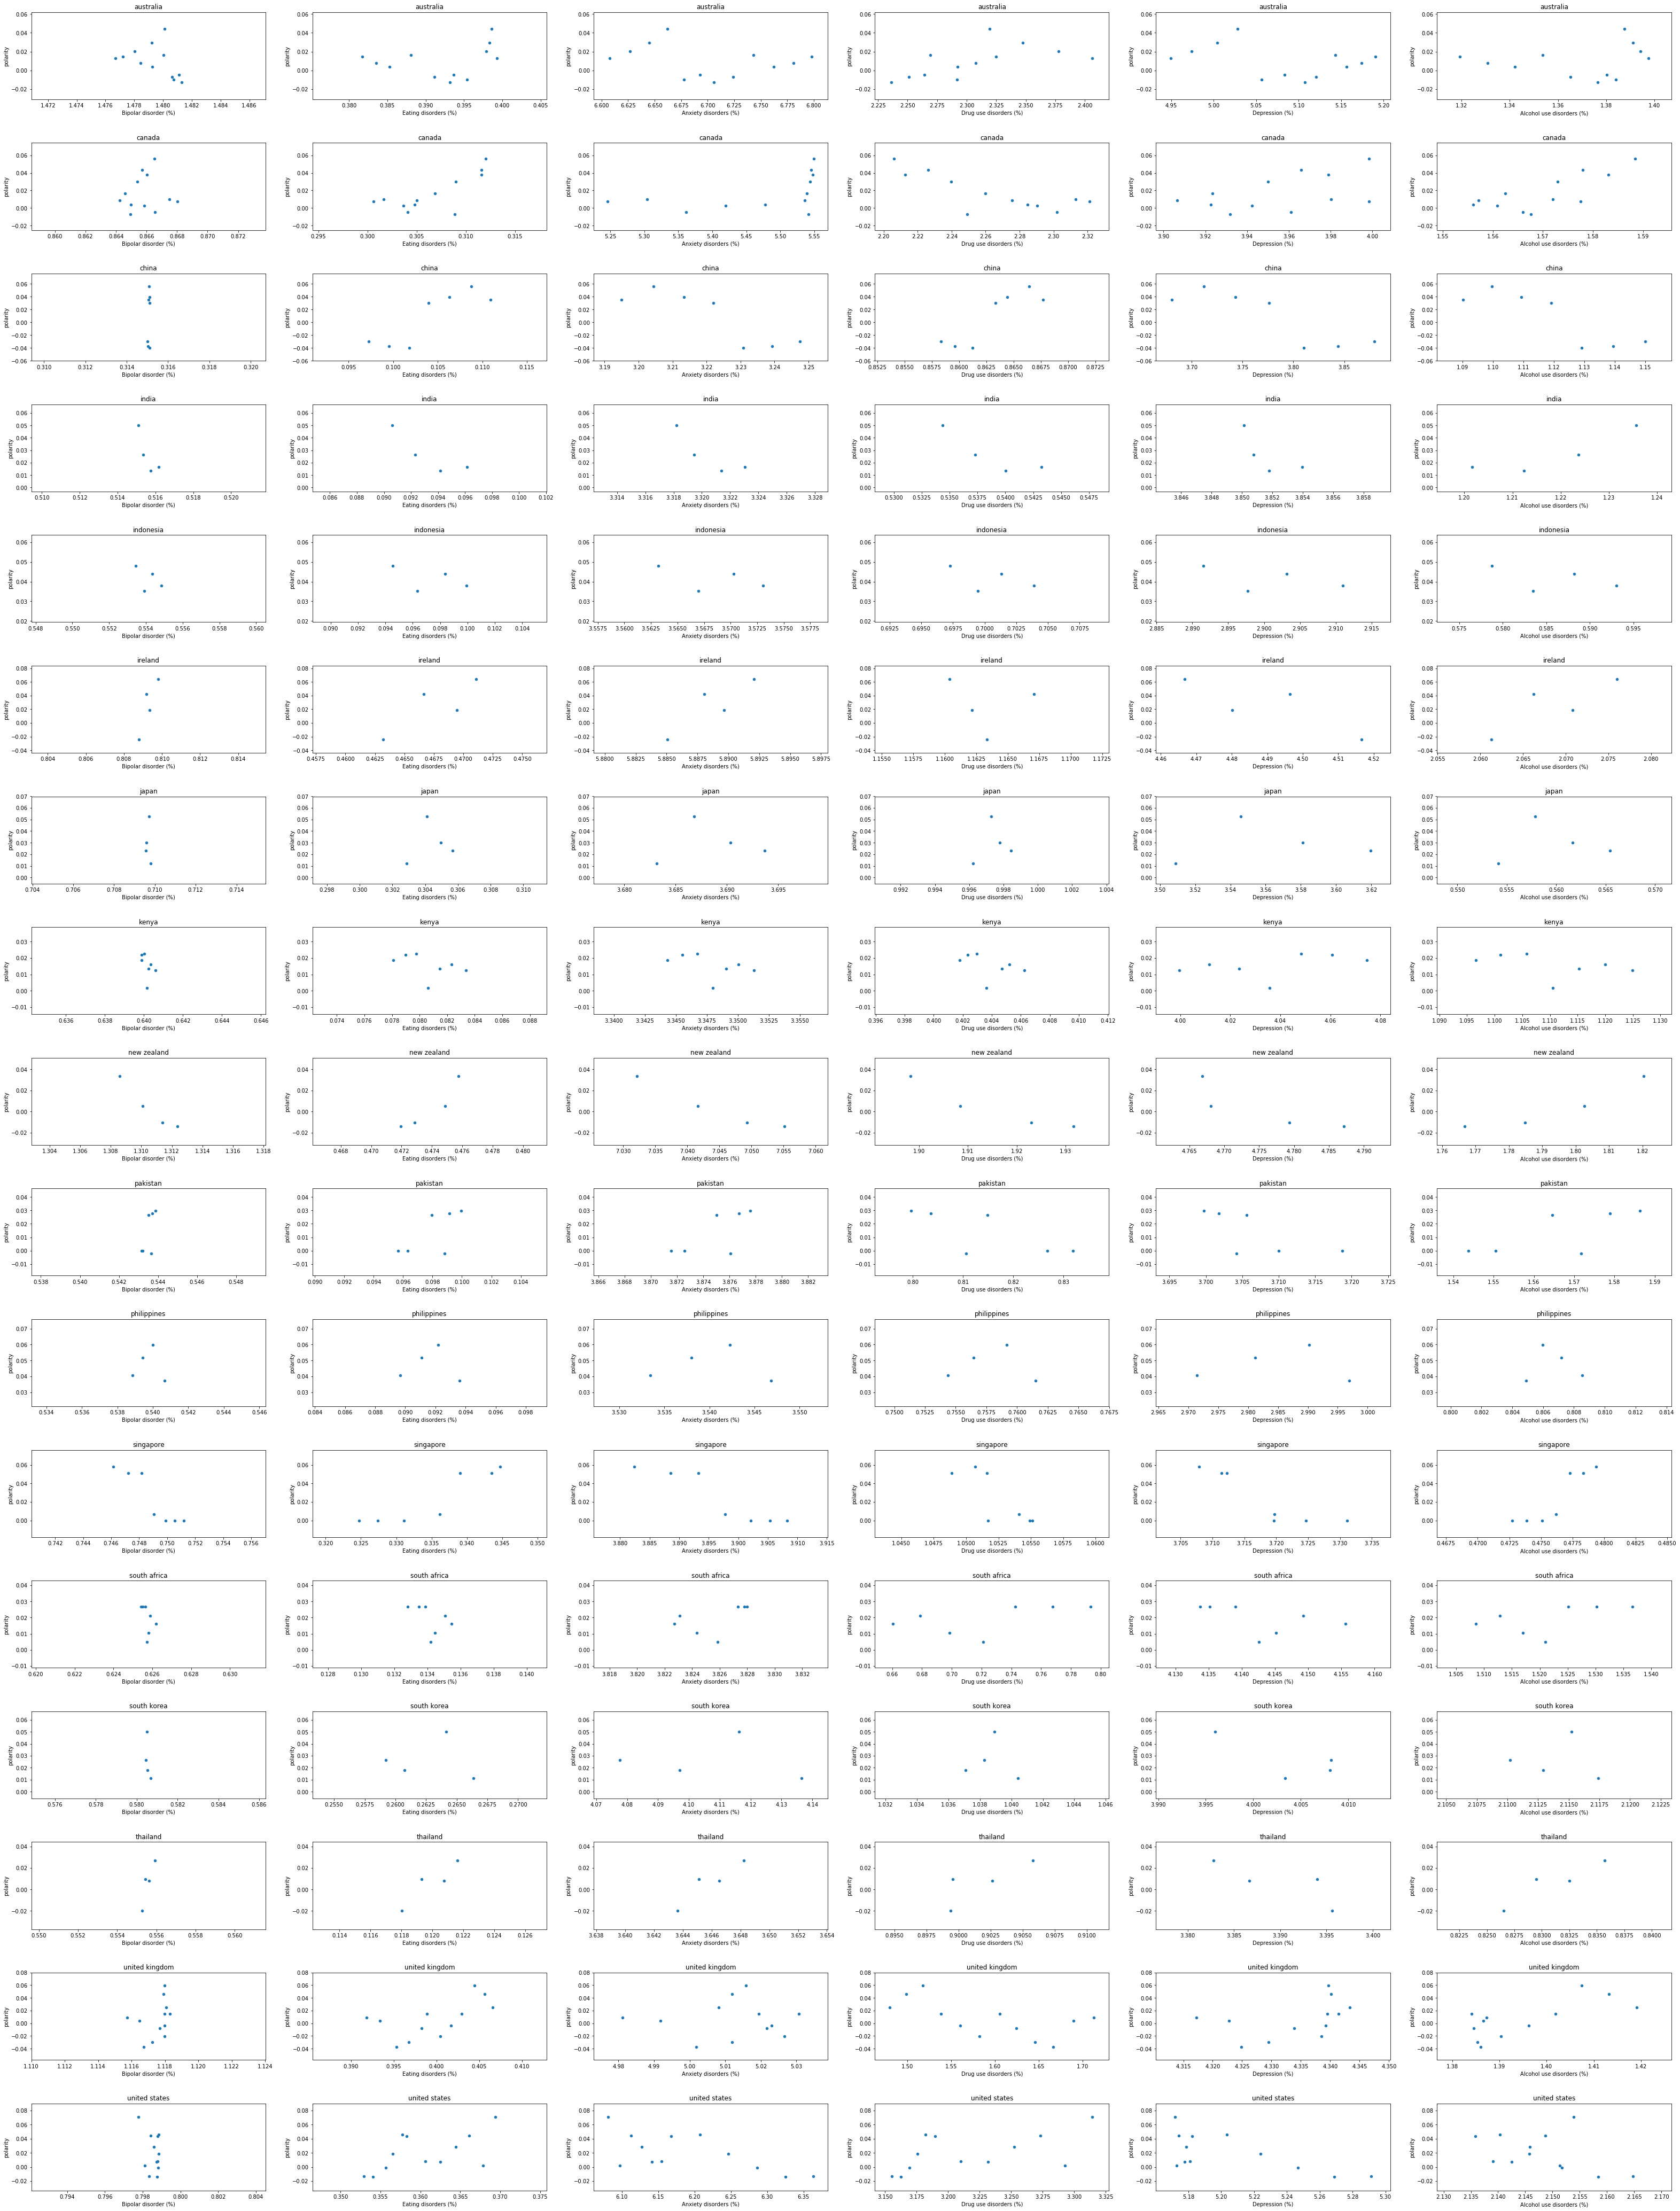

In [138]:
fig, axes = plt.subplots(nrows=joined_df['country'].nunique(),ncols=len(TARGETS), figsize=(55,75))
fig.subplots_adjust(hspace=0.5)
grouped_df = joined_df.groupby(['country'])

for idx, val in enumerate(grouped_df):
    key = val[0]
    item = val[1]
    for rdx,target in enumerate(TARGETS):
        item.plot(kind='scatter',x=target,y='polarity', title=key, ax=axes[idx,rdx])

# Defining Modeling Strategy

<b>Based on SelectKBest</b>

In [63]:
def run_select_k_best(x,y,grid_searcher_net,grid_searcher_linear,grid_searcher_forest,grid_searcher_svr,grid_searcher_knn):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    print('Columns in Training Data\n', x.columns)

    result_df = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score', 'Features'])

    grid_searcher_net.fit(x_train, y_train)
    print('\t****\tMULTI-LAYER PERCEPTRON\t****')
    print_stats(grid_searcher_net, x_test, y_test)
    result_df = append_score('Multi-Layer Perceptron', result_df, grid_searcher_net, x_test, y_test)

    grid_searcher_linear.fit(x_train, y_train)
    print('\t****\tLINEAR REGRESSOR\t****')
    print_stats(grid_searcher_linear, x_test, y_test)
    result_df = append_score('Linear Regressor', result_df, grid_searcher_linear, x_test, y_test)

    grid_searcher_forest.fit(x_train, y_train)
    print('\t****\tRANDOM FOREST REGRESSOR\t****')
    print_stats(grid_searcher_forest, x_test, y_test)
    result_df = append_score('Random Forest Regressor', result_df, grid_searcher_forest, x_test, y_test)

    grid_searcher_svr.fit(x_train, y_train)
    print('\t****\tSUPPORT VECTOR MACHINE\t****')
    print_stats(grid_searcher_svr, x_test, y_test)
    result_df = append_score('Support Vector Machine', result_df, grid_searcher_svr, x_test, y_test)

    grid_searcher_knn.fit(x_train, y_train)
    print('\t****\tK-NEAREST NEIGHBORS\t****')
    print_stats(grid_searcher_knn, x_test, y_test)
    result_df = append_score('k-Nearest Neighbors', result_df, grid_searcher_knn, x_test, y_test)
    
    return result_df

<b>Based on PCA</b>

In [67]:
def run_pca(x, y, grid_searcher_net_pca, grid_searcher_linear_pca, 
            grid_searcher_forest_pca, grid_searcher_svr_pca, grid_searcher_knn_pca):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
    print('Columns in Training Data\n', x.columns)
    
    result_df = pd.DataFrame(columns=['Model', 'Train Score', 'Test Score', 'Features'])
    
    grid_searcher_net_pca.fit(x_train, y_train)
    print('\t****\tMULTI-LAYER PERCEPTRON\t****')
    print_stats(grid_searcher_net_pca, x_test, y_test, pca=True)
    result_df = append_score('Multi-Layer Perceptron', result_df, grid_searcher_net_pca, x_test, y_test, pca=True)
    
    grid_searcher_linear_pca.fit(x_train, y_train)
    print('\t****\tLINEAR REGRESSOR\t****')
    print_stats(grid_searcher_linear_pca, x_test, y_test, pca=True)
    result_df = append_score('Linear Regressor', result_df, grid_searcher_linear_pca, x_test, y_test, pca=True)

    grid_searcher_forest_pca.fit(x_train, y_train)
    print('\t****\tRANDOM FOREST REGRESSOR\t****')
    print_stats(grid_searcher_forest_pca, x_test, y_test, pca=True)
    result_df = append_score('Random Forest Regressor', result_df, grid_searcher_forest_pca, x_test, y_test, pca=True)

    grid_searcher_svr_pca.fit(x_train, y_train)
    print('\t****\tSUPPORT VECTOR MACHINE\t****')
    print_stats(grid_searcher_svr_pca, x_test, y_test, pca=True)
    result_df = append_score('Support Vector Machine', result_df, grid_searcher_svr_pca, x_test, y_test, pca=True)

    grid_searcher_knn_pca.fit(x_train, y_train)
    print('\t****\tK-NEAREST NEIGHBORS\t****')
    print_stats(grid_searcher_knn_pca, x_test, y_test, pca=True)
    result_df = append_score('k-Nearest Neighbors', result_df, grid_searcher_knn_pca, x_test, y_test, pca=True)
    
    return result_df

# Training and Testing
Here we run the CV grid searcher for pipelines with parameters defined earlier. We try to predict each of the illness rates using the gathered features. This script takes a long time to run as it goes through every possible combinations of the provided parameters to find the best model for the job. The results are summed up in the dataframes below.

<h2>With all features</h2>

In [146]:
grid_searcher_net = generate_pipelined_grid_search(('net', net), net_parameters)
grid_searcher_linear = generate_pipelined_grid_search(('linear', linear), linear_parameters)
grid_searcher_forest = generate_pipelined_grid_search(('forest', forest), forest_parameters)
grid_searcher_svr = generate_pipelined_grid_search(('svr', svr), svr_parameters)
grid_searcher_knn = generate_pipelined_grid_search(('knn', knn), knn_parameters)
grid_searcher_net_pca = generate_pipelined_grid_search(('net', net), net_parameters, pca=True)
grid_searcher_linear_pca = generate_pipelined_grid_search(('linear', linear), linear_parameters, pca=True)
grid_searcher_forest_pca = generate_pipelined_grid_search(('forest', forest), forest_parameters, pca=True)
grid_searcher_svr_pca = generate_pipelined_grid_search(('svr', svr), svr_parameters, pca=True)
grid_searcher_knn_pca = generate_pipelined_grid_search(('knn', knn), knn_parameters, pca=True)

# Removing indexing columns (country, year) and rates that will not be predicted
results = []
for TARGET in TARGETS:
    y = joined_df.copy().pop(TARGET)
    x = joined_df.copy()[FEATURES]
    result_skb = run_select_k_best(x,y,grid_searcher_net,grid_searcher_linear,
                      grid_searcher_forest,grid_searcher_svr,grid_searcher_knn)
    result_pca = run_pca(x,y,grid_searcher_net_pca,grid_searcher_linear_pca,
            grid_searcher_forest_pca,grid_searcher_svr_pca,grid_searcher_knn_pca)
    result_target = {'target':TARGET,'SelectKBest': result_skb, 'PCA': result_pca}
    results.append(result_target)

Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1515 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1839 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   38.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   38.9s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 6} 

Train score: 0.34569495681995505
Test score: 0.597626899029558
Features used: ['HDI' 'polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.2321675272169768
Test score: 0.6287647592140425
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 4, 'forest__n_estimators': 20, 'selector__k': 7} 

Train score: 0.8989305374132479
Test score: 0.9519032289781075
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 1, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.410917637264077
Test score: 0.4411861161343329
Features used: ['urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 1} 

Train score: 0.750964360526676
Test score: 0.8791158809622398
Features used: ['urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   50.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.5s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': 50, 'net__learning_rate': 'invscaling', 'net__max_iter': 100, 'selector__n_components': 5} 

Train score: 0.41120916897866755
Test score: 0.45366485371831444
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 7} 

Train score: 0.23216752721697737
Test score: 0.6287647592140426
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='s...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__n_components': 3} 

Train score: 0.4607427705835333
Test score: 0.5991152925995438
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 7, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.3780294928389621
Test score: 0.8075884400866458
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done   9 out of 140 | elapsed:    0.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 7} 

Train score: 0.37625204004387136
Test score: 0.6415680347294792
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 1503 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 1827 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   33.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   34.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (150, 150), 'net__learning_rate': 'constant', 'net__max_iter': 100, 'selector__k': 7} 

Train score: 0.8719255912575975
Test score: 0.9341314977590284
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.8672041347534014
Test score: 0.9251741248684023
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1184 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1580 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 5, 'forest__n_estimators': 20, 'selector__k': 7} 

Train score: 0.9547902584166287
Test score: 0.9825030360732202
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 7, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.8981447549809652
Test score: 0.9355852825040203
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 7} 

Train score: 0.8871545301547132
Test score: 0.955748359514136
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1532 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1856 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.5s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (150, 150), 'net__learning_rate': 'invscaling', 'net__max_iter': 100, 'selector__n_components': 7} 

Train score: 0.8914396652770931
Test score: 0.8928707022352496
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=6, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 6} 

Train score: 0.8746685981695483
Test score: 0.9254615796503195
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='a...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 5, 'forest__n_estimators': 20, 'selector__n_components': 7} 

Train score: 0.9115065577040391
Test score: 0.9390641424928513
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 7, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.8981447549810035
Test score: 0.9355852825040128
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=6, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 6} 

Train score: 0.8894149211178327
Test score: 0.9554884656947122
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 1217 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 1685 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   58.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   59.2s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': 100, 'net__learning_rate': 'invscaling', 'net__max_iter': 1000, 'selector__k': 7} 

Train score: 0.7128709065190177
Test score: 0.8419287023136661
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.7039916938507242
Test score: 0.8623185517949138
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 925 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1501 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   26.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   26.8s finished


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__k': 6} 

Train score: 0.9631695709686847
Test score: 0.9713713942294355
Features used: ['HDI' 'polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 7, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.7357758163059575
Test score: 0.8857402238638655
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 7} 

Train score: 0.6760881468825559
Test score: 0.897100082257263
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 351 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 606 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1087 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1790 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  2.3min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__n_components': 7} 

Train score: 0.8307349964915826
Test score: 0.9507621633249581
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 7} 

Train score: 0.7039916938507245
Test score: 0.8623185517949139
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='a...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 4, 'forest__n_estimators': 50, 'selector__n_components': 7} 

Train score: 0.7283916958353114
Test score: 0.8097032499413742
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 7, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.7357758163059568
Test score: 0.8857402238638654
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 4} 

Train score: 0.6862904991900391
Test score: 0.8726350004533114
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1033 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 1231 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 1465 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1735 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  2.1min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 4} 

Train score: 0.8511117813969522
Test score: 0.8611133539772243
Features used: ['GDP' 'HDI' 'polarity' 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.5385952601818397
Test score: 0.5847937320725243
Features used: ['polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 916 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1636 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 50, 'selector__k': 7} 

Train score: 0.9851253769144624
Test score: 0.995956769009169
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 4, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.6818126518774595
Test score: 0.7196022374297824
Features used: ['GDP' 'HDI' 'polarity' 'urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 1} 

Train score: 0.6730810347182514
Test score: 0.6566000444485844
Features used: ['urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 819 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1241 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1439 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1673 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  2.1min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=6, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'invscaling', 'net__max_iter': 1000, 'selector__n_components': 6} 

Train score: 0.6771489230874839
Test score: 0.8731457785896285
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 4} 

Train score: 0.5922503244532245
Test score: 0.6336569505088924
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='a...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__n_components': 7} 

Train score: 0.6824879226090443
Test score: 0.7052860516995847
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 5, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.637223386250376
Test score: 0.6603576984981587
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 4} 

Train score: 0.6091909793849788
Test score: 0.7335698252029158
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1115 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1511 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   50.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   50.2s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': 100, 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 7} 

Train score: 0.41052879829699856
Test score: 0.5855189838845936
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.37095982544414546
Test score: 0.6557824059133204
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   25.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__k': 4} 

Train score: 0.803665402679705
Test score: 0.8648955457743852
Features used: ['GDP' 'HDI' 'polarity' 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 6, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.48118705838983117
Test score: 0.6064044879568091
Features used: ['HDI' 'polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=2, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 2} 

Train score: 0.5386125954084938
Test score: 0.7063581042668803
Features used: ['HDI' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1118 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 1514 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   50.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=6, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (50, 50), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__n_components': 6} 

Train score: 0.48611861002585766
Test score: 0.6590506000554042
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 5} 

Train score: 0.3961770059492026
Test score: 0.49281500436119546
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1265 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1589 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 1875 out of 1890 | elapsed:   27.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='s...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 2, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 20, 'selector__n_components': 4} 

Train score: 0.4757256751931777
Test score: 0.4826897869959593
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.4570965084988465
Test score: 0.5808799155913966
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 4} 

Train score: 0.4227355073165673
Test score: 0.643016037621627
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   49.9s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 6} 

Train score: 0.42659771706697636
Test score: 0.6355681892841781
Features used: ['HDI' 'polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=7, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 7} 

Train score: 0.21844787488271214
Test score: 0.45589046330056443
Features used: ['GDP' 'HDI' 'polarity' 'population density' 'subjectivity'
 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1126 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1846 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=6, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 4, 'forest__n_estimators': 10, 'selector__k': 6} 

Train score: 0.7708063093516238
Test score: 0.8853932313940872
Features used: ['HDI' 'polarity' 'population density' 'subjectivity' 'unemployment rate'
 'urban density (%)']
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.5,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 1, 'svr__C': 100, 'svr__epsilon': 0.5} 

Train score: 0.374158960312048
Test score: 0.5808530697537859
Features used: ['urban density (%)']
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.5s finished


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 1} 

Train score: 0.4628444998037312
Test score: 0.7276733049244939
Features used: ['urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'polarity', 'population density', 'subjectivity',
       'unemployment rate', 'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1354 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:  1.2min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__n_components': 7} 

Train score: 0.5150728243933329
Test score: 0.8686984127950159
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  70 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 5} 

Train score: 0.24372740536054063
Test score: 0.36581780251774787
Fitting 5 folds for each of 378 candidates, totalling 1890 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1470 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1794 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1890 out of 1890 | elapsed:   20.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=7, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='a...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__n_components': 7} 

Train score: 0.3783063356772286
Test score: 0.5766381227495713
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.3238686285511571
Test score: 0.5168578826280247
Fitting 5 folds for each of 28 candidates, totalling 140 fits
	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',

[Parallel(n_jobs=-1)]: Done  96 out of 140 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.4s finished


<h2>Without Sentiment</h2>

In [144]:
grid_searcher_net = generate_pipelined_grid_search(('net', net), net_parameters, no_of_features=len(FEATURES)-1)
grid_searcher_linear = generate_pipelined_grid_search(('linear', linear), linear_parameters, no_of_features=len(FEATURES)-1)
grid_searcher_forest = generate_pipelined_grid_search(('forest', forest), forest_parameters, no_of_features=len(FEATURES)-1)
grid_searcher_svr = generate_pipelined_grid_search(('svr', svr), svr_parameters, no_of_features=len(FEATURES)-1)
grid_searcher_knn = generate_pipelined_grid_search(('knn', knn), knn_parameters, no_of_features=len(FEATURES)-1)
grid_searcher_net_pca = generate_pipelined_grid_search(('net', net), net_parameters, pca=True, no_of_features=len(FEATURES)-1)
grid_searcher_linear_pca = generate_pipelined_grid_search(('linear', linear), linear_parameters, pca=True, no_of_features=len(FEATURES)-1)
grid_searcher_forest_pca = generate_pipelined_grid_search(('forest', forest), forest_parameters, pca=True, no_of_features=len(FEATURES)-1)
grid_searcher_svr_pca = generate_pipelined_grid_search(('svr', svr), svr_parameters, pca=True, no_of_features=len(FEATURES)-1)
grid_searcher_knn_pca = generate_pipelined_grid_search(('knn', knn), knn_parameters, pca=True, no_of_features=len(FEATURES)-1)

# Running the tests without sentiment included
results_without_sentiment = []
for TARGET in TARGETS:
    y = joined_df.copy().pop(TARGET)
    x = joined_df.copy()[FEATURES]
    x = x.drop(['polarity','subjectivity'], 1)
    result_skb = run_select_k_best(x,y,grid_searcher_net,grid_searcher_linear,
                      grid_searcher_forest,grid_searcher_svr,grid_searcher_knn)
    result_pca = run_pca(x,y,grid_searcher_net_pca,grid_searcher_linear_pca,
            grid_searcher_forest_pca,grid_searcher_svr_pca,grid_searcher_knn_pca)
    result_target = {'target':TARGET,'SelectKBest': result_skb, 'PCA': result_pca}
    results_without_sentiment.append(result_target)

Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   25.0s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'invscaling', 'net__max_iter': 1000, 'selector__k': 4} 

Train score: 0.38290956374313156
Test score: 0.5785481873408355
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.28800720848726147
Test score: 0.6400000328253821
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 4, 'forest__n_estimators': 50, 'selector__k': 4} 

Train score: 0.9069468727016405
Test score: 0.9295156157063169
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 4, 'svr__C': 1, 'svr__epsilon': 0.01} 

Train score: 0.41683118373484745
Test score: 0.4353412768919214
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 1} 

Train score: 0.750964360526676
Test score: 0.8791158809622398
Features used: ['urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   26.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.1s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': 100, 'net__learning_rate': 'invscaling', 'net__max_iter': 100, 'selector__n_components': 3} 

Train score: 0.4692201680155906
Test score: 0.6438984560641624
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 3} 

Train score: 0.2896151782141308
Test score: 0.5496203836284355
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   11.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='l...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'log2', 'forest__min_samples_split': 5, 'forest__n_estimators': 50, 'selector__n_components': 5} 

Train score: 0.6546396817166521
Test score: 0.7295192833704648
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 1, 'svr__epsilon': 0.01} 

Train score: 0.4055364863264699
Test score: 0.47992706078260616
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 5} 

Train score: 0.5786309042590227
Test score: 0.7687406293065133
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__k': 5} 

Train score: 0.8943029959449134
Test score: 0.6394629345918865
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.8732084319314823
Test score: 0.9210493785408792
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__k': 4} 

Train score: 0.9648583472703355
Test score: 0.9925537154530053
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 5, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.9075120095329275
Test score: 0.9323988612388106
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 5} 

Train score: 0.9173128755252397
Test score: 0.9466217510554428
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1156 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   18.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'constant', 'net__max_iter': 100, 'selector__n_components': 5} 

Train score: 0.8998958936052165
Test score: 0.9454621051117373
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 4} 

Train score: 0.8783287008762373
Test score: 0.9210847109029904
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1090 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='a...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 4, 'forest__n_estimators': 10, 'selector__n_components': 4} 

Train score: 0.9337923393989799
Test score: 0.9467586924085245
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 5, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.9075120095329612
Test score: 0.9323988612388099
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 2} 

Train score: 0.9191370049400306
Test score: 0.9421999955645916
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 715 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 913 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1147 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   57.9s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (50, 50), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 4} 

Train score: 0.8566096456432296
Test score: 0.9376961287338348
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.6938674526856248
Test score: 0.8918472430718443
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 925 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1335 out of 1350 | elapsed:   18.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 50, 'selector__k': 4} 

Train score: 0.9691712203030893
Test score: 0.9868735875435762
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 5, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.7303642303355848
Test score: 0.9040910130838005
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 4} 

Train score: 0.8014951867668605
Test score: 0.9416698209005532
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 916 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1114 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.4min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__n_components': 4} 

Train score: 0.8619354843371009
Test score: 0.9068402690908007
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 5} 

Train score: 0.6938674526856249
Test score: 0.891847243071844
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='s...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 10, 'selector__n_components': 5} 

Train score: 0.8790512876744393
Test score: 0.9231873416112238
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.752082404354604
Test score: 0.8900077772514798
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  22 out of 100 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 3} 

Train score: 0.7937905255619128
Test score: 0.8623406508178779
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 1011 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 1245 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.5min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=3, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'adaptive', 'net__max_iter': 1000, 'selector__k': 3} 

Train score: 0.8674516778819316
Test score: 0.8966145864351501
Features used: ['population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=3, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 3} 

Train score: 0.5454757971777479
Test score: 0.6396616718941108
Features used: ['population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'auto', 'forest__min_samples_split': 3, 'forest__n_estimators': 20, 'selector__k': 4} 

Train score: 0.9872398862095026
Test score: 0.9986863418552658
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=3, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 3, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.73095480287569
Test score: 0.7203937408004389
Features used: ['population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=1, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 1} 

Train score: 0.6730810347182514
Test score: 0.6566000444485844
Features used: ['urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 1190 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.3min finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'invscaling', 'net__max_iter': 1000, 'selector__n_components': 4} 

Train score: 0.8948733413528503
Test score: 0.9128092711885792
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 3} 

Train score: 0.6254674526116443
Test score: 0.7272735978237154
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='l...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'log2', 'forest__min_samples_split': 5, 'forest__n_estimators': 10, 'selector__n_components': 5} 

Train score: 0.7287071253295265
Test score: 0.8369377710265429
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 10, 'svr__epsilon': 0.1} 

Train score: 0.6593688261874066
Test score: 0.7335658028636051
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 3} 

Train score: 0.6667393563711719
Test score: 0.8011981743625156
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 557 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 881 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1277 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1335 out of 1350 | elapsed:   43.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   43.3s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (50, 50), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__k': 5} 

Train score: 0.4748696035338351
Test score: 0.2950624390495067
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.38351326093237154
Test score: 0.649841199093707
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'sqrt', 'forest__min_samples_split': 3, 'forest__n_estimators': 50, 'selector__k': 4} 

Train score: 0.8384223330541476
Test score: 0.8792069203407598
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 4, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.499429484221777
Test score: 0.5893722335424341
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 4} 

Train score: 0.6455346451949776
Test score: 0.7824251744886159
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 366 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1085 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1335 out of 1350 | elapsed:   32.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   33.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (50, 50), 'net__learning_rate': 'constant', 'net__max_iter': 1000, 'selector__n_components': 3} 

Train score: 0.5236871715380139
Test score: 0.6636757567154326
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 3} 

Train score: 0.40311718617362446
Test score: 0.5219970163157132
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='l...ators=50, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'log2', 'forest__min_samples_split': 5, 'forest__n_estimators': 50, 'selector__n_components': 2} 

Train score: 0.6796566462335679
Test score: 0.6742956118162995
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 3, 'svr__C': 10, 'svr__epsilon': 0.01} 

Train score: 0.5148644300678407
Test score: 0.6819132334424065
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=3, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__n_components': 3} 

Train score: 0.6141364138811755
Test score: 0.7749977469098218
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   38.6s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidde...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'invscaling', 'net__max_iter': 100, 'selector__k': 4} 

Train score: 0.37868259668022664
Test score: 0.614521238729804
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__k': 5} 

Train score: 0.25389672900731963
Test score: 0.4661379874997992
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=5, score_func=<function f_classif at 0x111E6A50>)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='log2', max_leaf_nodes=None,
           min_impurity...ators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'log2', 'forest__min_samples_split': 3, 'forest__n_estimators': 20, 'selector__k': 5} 

Train score: 0.830608486660584
Test score: 0.8852538776265948
Features used: ['GDP' 'HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__k': 4, 'svr__C': 100, 'svr__epsilon': 0.1} 

Train score: 0.47510532995456306
Test score: 0.5562211451099368
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', SelectKBest(k=4, score_func=<function f_classif at 0x111E6A50>)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]) 

Best parameters: {'knn__n_neighbors': 5, 'selector__k': 4} 

Train score: 0.6157907212578687
Test score: 0.7668549498710615
Features used: ['HDI' 'population density' 'unemployment rate' 'urban density (%)']
Columns in Training Data
 Index(['GDP', 'HDI', 'population density', 'unemployment rate',
       'urban density (%)'],
      dtype='object')
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 460 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 984 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   46.3s finished


	****	MULTI-LAYER PERCEPTRON	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('net', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999,...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]) 

Best parameters: {'net__hidden_layer_sizes': (100, 100, 100), 'net__learning_rate': 'invscaling', 'net__max_iter': 1000, 'selector__n_components': 5} 

Train score: 0.6336759592892736
Test score: 0.8114980201273101
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	LINEAR REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]) 

Best parameters: {'linear__fit_intercept': True, 'selector__n_components': 4} 

Train score: 0.255182575681798
Test score: 0.4711752705438431
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1335 out of 1350 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	****	RANDOM FOREST REGRESSOR	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='l...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]) 

Best parameters: {'forest__max_depth': 5, 'forest__max_features': 'log2', 'forest__min_samples_split': 4, 'forest__n_estimators': 10, 'selector__n_components': 2} 

Train score: 0.6589521270591714
Test score: 0.635740510657116
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


	****	SUPPORT VECTOR MACHINE	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('svr', SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]) 

Best parameters: {'selector__n_components': 5, 'svr__C': 100, 'svr__epsilon': 0.01} 

Train score: 0.4649234286167551
Test score: 0.5810711764770045
Fitting 5 folds for each of 20 candidates, totalling 100 fits
	****	K-NEAREST NEIGHBORS	****
Best estimator
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('selector', PCA(copy=True, iterated_power='auto', n_components=5, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkows

[Parallel(n_jobs=-1)]: Done  64 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


# Results - With Sentiment

Results trying to predict Bipolar disorder (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.345695,0.597627,"[HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Linear Regressor,0.232168,0.628765,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.898931,0.951903,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.410918,0.441186,[urban density (%)]
0,k-Nearest Neighbors,0.750964,0.879116,[urban density (%)]


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.411209,0.453665,PCA - N/A
0,Linear Regressor,0.232168,0.628765,PCA - N/A
0,Random Forest Regressor,0.460743,0.599115,PCA - N/A
0,Support Vector Machine,0.378029,0.807588,PCA - N/A
0,k-Nearest Neighbors,0.376252,0.641568,PCA - N/A


Results trying to predict Eating disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.871926,0.934131,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Linear Regressor,0.867204,0.925174,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.954790,0.982503,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.898145,0.935585,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.887155,0.955748,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.891440,0.892871,PCA - N/A
0,Linear Regressor,0.874669,0.925462,PCA - N/A
0,Random Forest Regressor,0.911507,0.939064,PCA - N/A
0,Support Vector Machine,0.898145,0.935585,PCA - N/A
0,k-Nearest Neighbors,0.889415,0.955488,PCA - N/A


Results trying to predict Anxiety disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.712871,0.841929,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Linear Regressor,0.703992,0.862319,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.963170,0.971371,"[HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.735776,0.885740,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.676088,0.897100,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.830735,0.950762,PCA - N/A
0,Linear Regressor,0.703992,0.862319,PCA - N/A
0,Random Forest Regressor,0.728392,0.809703,PCA - N/A
0,Support Vector Machine,0.735776,0.885740,PCA - N/A
0,k-Nearest Neighbors,0.686290,0.872635,PCA - N/A


Results trying to predict Drug use disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.851112,0.861113,"[GDP, HDI, polarity, urban density (%)]"
0,Linear Regressor,0.538595,0.584794,"[polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.985125,0.995957,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.681813,0.719602,"[GDP, HDI, polarity, urban density (%)]"
0,k-Nearest Neighbors,0.673081,0.656600,[urban density (%)]


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.677149,0.873146,PCA - N/A
0,Linear Regressor,0.592250,0.633657,PCA - N/A
0,Random Forest Regressor,0.682488,0.705286,PCA - N/A
0,Support Vector Machine,0.637223,0.660358,PCA - N/A
0,k-Nearest Neighbors,0.609191,0.733570,PCA - N/A


Results trying to predict Depression (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.410529,0.585519,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Linear Regressor,0.370960,0.655782,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.803665,0.864896,"[GDP, HDI, polarity, urban density (%)]"
0,Support Vector Machine,0.481187,0.606404,"[HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.538613,0.706358,"[HDI, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.486119,0.659051,PCA - N/A
0,Linear Regressor,0.396177,0.492815,PCA - N/A
0,Random Forest Regressor,0.475726,0.482690,PCA - N/A
0,Support Vector Machine,0.457097,0.580880,PCA - N/A
0,k-Nearest Neighbors,0.422736,0.643016,PCA - N/A


Results trying to predict Alcohol use disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.426598,0.635568,"[HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Linear Regressor,0.218448,0.455890,"[GDP, HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.770806,0.885393,"[HDI, polarity, population density, subjectivity, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.374159,0.580853,[urban density (%)]
0,k-Nearest Neighbors,0.462844,0.727673,[urban density (%)]


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.515073,0.868698,PCA - N/A
0,Linear Regressor,0.243727,0.365818,PCA - N/A
0,Random Forest Regressor,0.378306,0.576638,PCA - N/A
0,Support Vector Machine,0.323869,0.516858,PCA - N/A
0,k-Nearest Neighbors,0.272751,0.664080,PCA - N/A


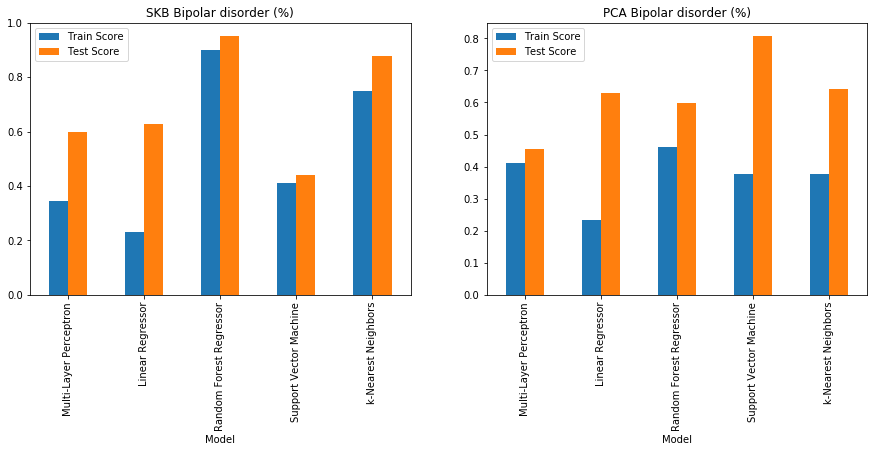

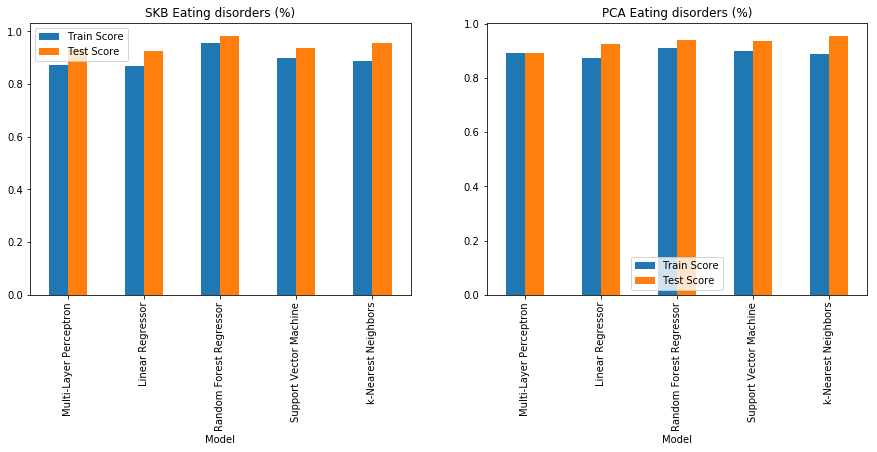

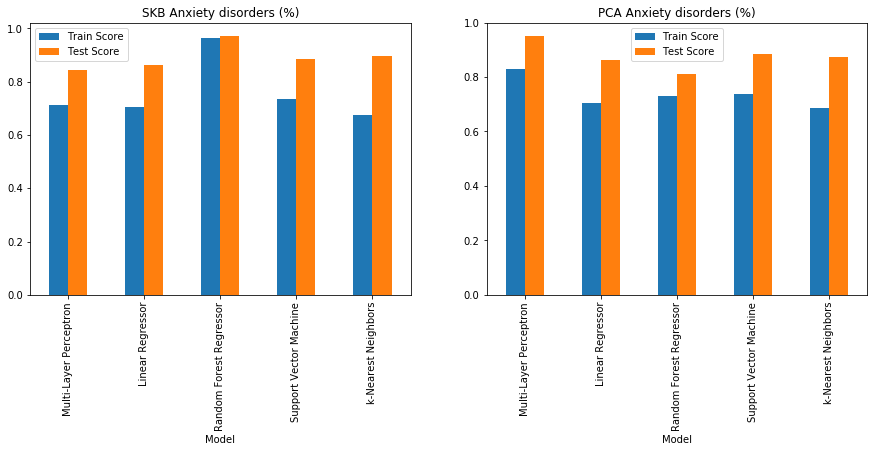

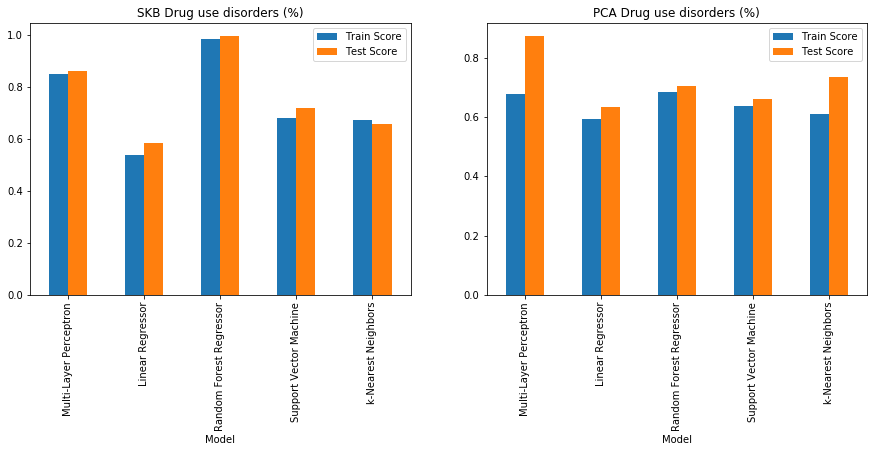

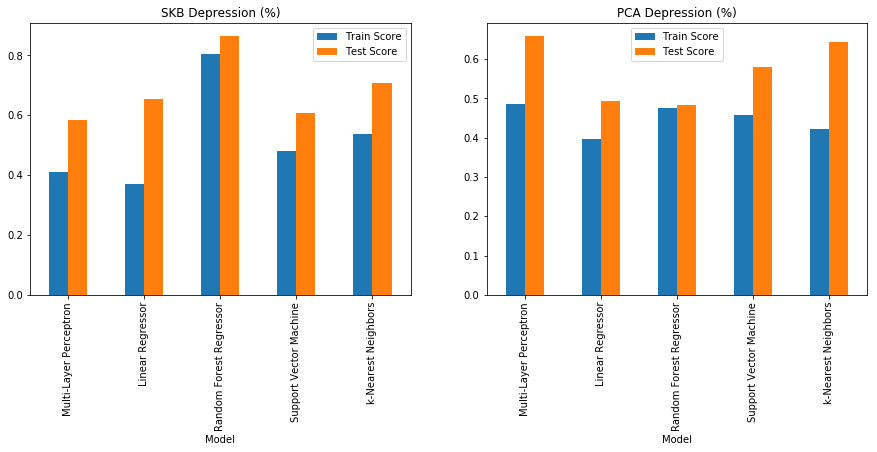

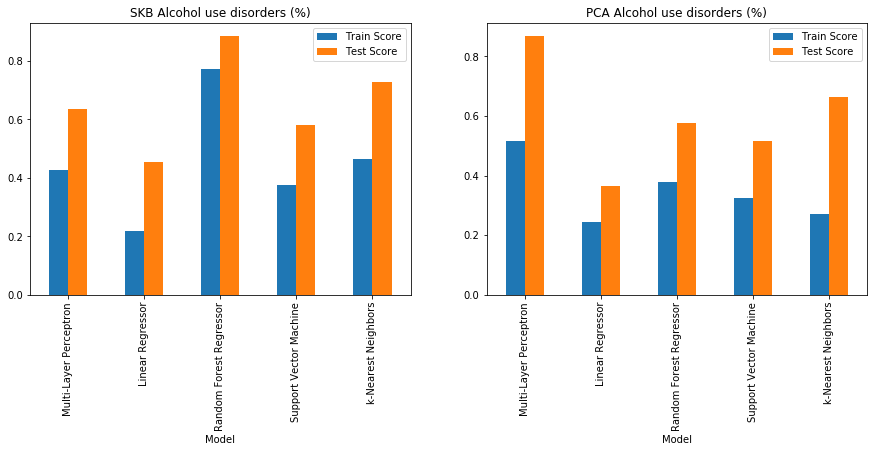

In [147]:
from IPython.display import display, HTML
import copy
pd.set_option('display.max_colwidth', -1)

result_to_iterate = copy.deepcopy(results)
for result in result_to_iterate:
    
    print('\033[1m'+"Results trying to predict", result['target'])
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    # Display and draw graph for SelectKBest
    df = result['SelectKBest']
    display(HTML(df.to_html()))  
    ax = df.set_index('Model').plot(kind = 'bar', title='SKB '+result['target'], ax=ax)
    
    # Display and draw graph for PCA
    df = result['PCA']
    display(HTML(df.to_html()))
    ax = df.set_index('Model').plot(kind = 'bar', title='PCA '+result['target'], ax=ax2)

# Results - Without Sentiment

Results trying to predict Bipolar disorder (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.382910,0.578548,"[HDI, population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.288007,0.640000,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.906947,0.929516,"[HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.416831,0.435341,"[HDI, population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.750964,0.879116,[urban density (%)]


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.469220,0.643898,PCA - N/A
0,Linear Regressor,0.289615,0.549620,PCA - N/A
0,Random Forest Regressor,0.654640,0.729519,PCA - N/A
0,Support Vector Machine,0.405536,0.479927,PCA - N/A
0,k-Nearest Neighbors,0.578631,0.768741,PCA - N/A


Results trying to predict Eating disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.894303,0.639463,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.873208,0.921049,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.964858,0.992554,"[HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.907512,0.932399,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.917313,0.946622,"[GDP, HDI, population density, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.899896,0.945462,PCA - N/A
0,Linear Regressor,0.878329,0.921085,PCA - N/A
0,Random Forest Regressor,0.933792,0.946759,PCA - N/A
0,Support Vector Machine,0.907512,0.932399,PCA - N/A
0,k-Nearest Neighbors,0.919137,0.942200,PCA - N/A


Results trying to predict Anxiety disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.856610,0.937696,"[HDI, population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.693867,0.891847,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.969171,0.986874,"[HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.730364,0.904091,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.801495,0.941670,"[HDI, population density, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.861935,0.906840,PCA - N/A
0,Linear Regressor,0.693867,0.891847,PCA - N/A
0,Random Forest Regressor,0.879051,0.923187,PCA - N/A
0,Support Vector Machine,0.752082,0.890008,PCA - N/A
0,k-Nearest Neighbors,0.793791,0.862341,PCA - N/A


Results trying to predict Drug use disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.867452,0.896615,"[population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.545476,0.639662,"[population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.987240,0.998686,"[HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.730955,0.720394,"[population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.673081,0.656600,[urban density (%)]


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.894873,0.912809,PCA - N/A
0,Linear Regressor,0.625467,0.727274,PCA - N/A
0,Random Forest Regressor,0.728707,0.836938,PCA - N/A
0,Support Vector Machine,0.659369,0.733566,PCA - N/A
0,k-Nearest Neighbors,0.666739,0.801198,PCA - N/A


Results trying to predict Depression (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.474870,0.295062,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.383513,0.649841,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.838422,0.879207,"[HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.499429,0.589372,"[HDI, population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.645535,0.782425,"[HDI, population density, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.523687,0.663676,PCA - N/A
0,Linear Regressor,0.403117,0.521997,PCA - N/A
0,Random Forest Regressor,0.679657,0.674296,PCA - N/A
0,Support Vector Machine,0.514864,0.681913,PCA - N/A
0,k-Nearest Neighbors,0.614136,0.774998,PCA - N/A


Results trying to predict Alcohol use disorders (%)


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.378683,0.614521,"[HDI, population density, unemployment rate, urban density (%)]"
0,Linear Regressor,0.253897,0.466138,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Random Forest Regressor,0.830608,0.885254,"[GDP, HDI, population density, unemployment rate, urban density (%)]"
0,Support Vector Machine,0.475105,0.556221,"[HDI, population density, unemployment rate, urban density (%)]"
0,k-Nearest Neighbors,0.615791,0.766855,"[HDI, population density, unemployment rate, urban density (%)]"


,Model,Train Score,Test Score,Features
0,Multi-Layer Perceptron,0.633676,0.811498,PCA - N/A
0,Linear Regressor,0.255183,0.471175,PCA - N/A
0,Random Forest Regressor,0.658952,0.635741,PCA - N/A
0,Support Vector Machine,0.464923,0.581071,PCA - N/A
0,k-Nearest Neighbors,0.528132,0.725446,PCA - N/A


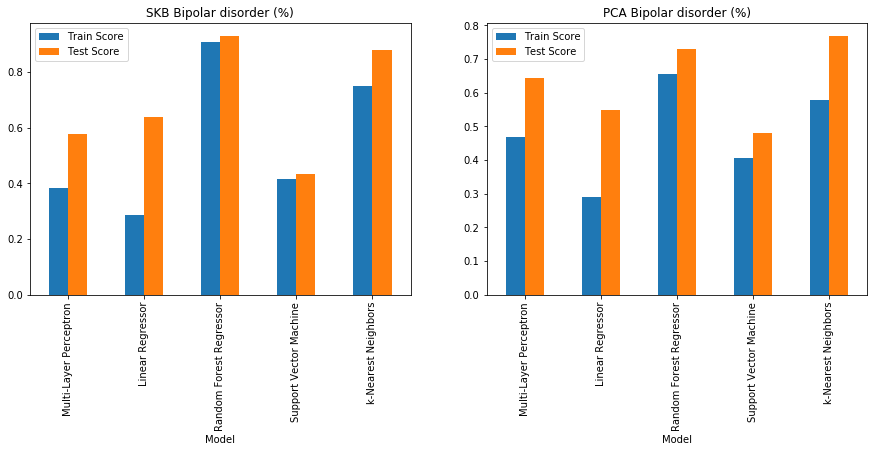

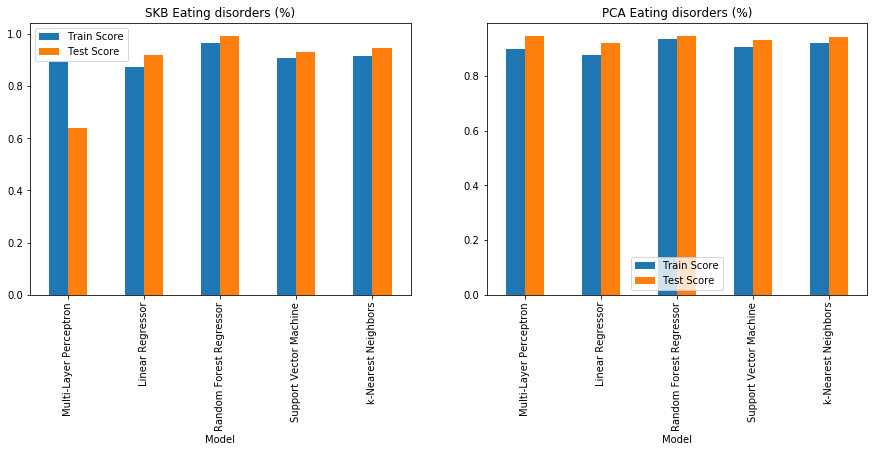

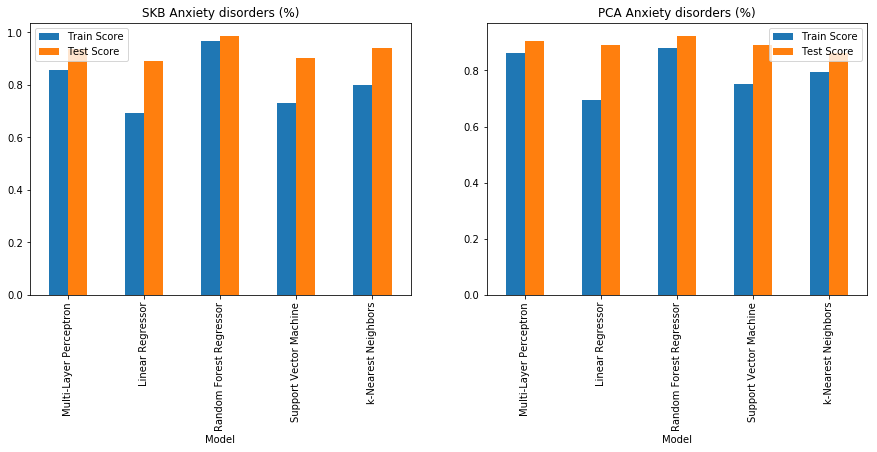

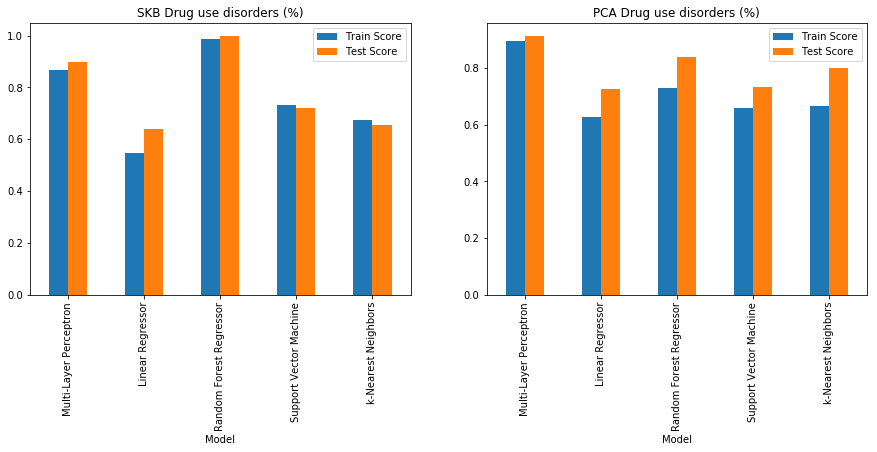

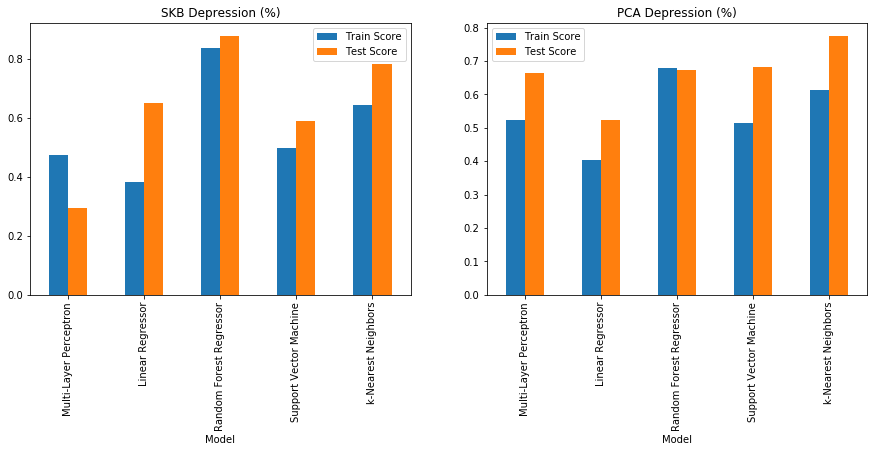

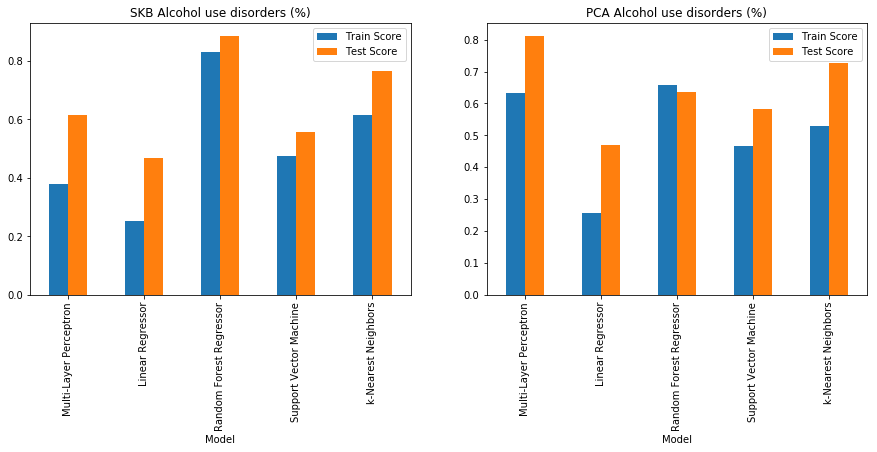

In [145]:
result_to_iterate = copy.deepcopy(results_without_sentiment)
for result in result_to_iterate:
    
    print('\033[1m'+"Results trying to predict", result['target'])
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    
    # Display and draw graph for SelectKBest
    df = result['SelectKBest']
    display(HTML(df.to_html()))  
    ax = df.set_index('Model').plot(kind = 'bar', title='SKB '+result['target'], ax=ax)
    
    # Display and draw graph for PCA
    df = result['PCA']
    display(HTML(df.to_html()))
    ax = df.set_index('Model').plot(kind = 'bar', title='PCA '+result['target'], ax=ax2)

# Statistical Analysis of Results

The data collected above suggests that Random Forest Regressors are the best candidates for estimation of anxiety rates. The hyper-parameters used in the pipelines for the sentiment and no-sentiment groups are used.

### No Sentiment

In [18]:
TARGET='Anxiety disorders (%)'
y = joined_df.copy().pop(TARGET)
x = joined_df.copy()[FEATURES]
x = x.drop(['polarity','subjectivity'], 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

test_scores_no_sentiment = list()

for i in range(30):
    rfe_no_sentiment = RandomForestRegressor(
        max_depth=5,
        max_features='sqrt',
        min_samples_split=3,
        n_estimators=50
    )

    select_no_sentiment = SelectKBest(k=4)

    scaler_no_sentiment = MinMaxScaler()

    pipeline_no_sentiment = Pipeline(
        steps=[
            ('scaler', scaler_no_sentiment),
            ('selector', select_no_sentiment),
            ('estimator', rfe_no_sentiment),
        ]
    )
    
    pipeline_no_sentiment.fit(x_train, y_train)
    test_scores_no_sentiment.append(pipeline_no_sentiment.score(x_test, y_test))
    
print('\n'.join('{}'.format(score) for score in test_scores_no_sentiment))



0.9862710799763104
0.9866073220986075
0.988942392907647
0.98820048197928
0.9898910815835961
0.9886083146831474
0.9897392977314332
0.9857056276233931
0.9883535663705272
0.9861827985844146
0.9764834308472605
0.9895969073008084
0.9880997663906194
0.9881646114953538
0.9874899762483126
0.9881112861886361
0.9894423006015127
0.9891596482252984
0.9896406667696444
0.9863250503753268
0.9832619145169885
0.9878441907655356
0.9856605058398428
0.9845151827043088
0.9859888805814944
0.9879984190428683
0.9860852004717171
0.9857045508175388
0.9872196471392025
0.9820430621076762


### Sentiment

In [21]:
TARGET='Anxiety disorders (%)'
y = joined_df.copy().pop(TARGET)
x = joined_df.copy()[FEATURES]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

test_scores = list()

for i in range(30):
#     rfe = RandomForestRegressor(
#         max_depth=5,
#         max_features='sqrt',
#         min_samples_split=3,
#         n_estimators=10
#     )

    rfe = RandomForestRegressor(
        max_depth=5,
        max_features='sqrt',
        min_samples_split=3,
        n_estimators=50
    )

    select = SelectKBest(k=6)

    scaler = MinMaxScaler()

    pipeline = Pipeline(
        steps=[
            ('scaler', scaler),
            ('selector', select),
            ('estimator', rfe),
        ]
    )
    
    pipeline.fit(x_train, y_train)
    test_scores.append(pipeline.score(x_test, y_test))
    
print('\n'.join('{}'.format(score) for score in test_scores))

0.9683037088081416
0.9819568087978365
0.9663963489730717
0.9656048789280907
0.979261665452429
0.9775301432064544
0.9748488439173189
0.9721475703853257
0.9768192022976259
0.9729586911989628
0.9815881306021516
0.9759936962512152
0.9715828093493083
0.9790806954190123
0.9713798726435843
0.9786305953193953
0.9709415736317513
0.9627355338447917
0.9752660363391065
0.967857349762964
0.9782768162242244
0.9725039963089869
0.9727142942267955
0.9792026564054311
0.981872388295682
0.9741787683806563
0.9762576914036502
0.9710872324369024
0.9797794990718486
0.9791156535610009
